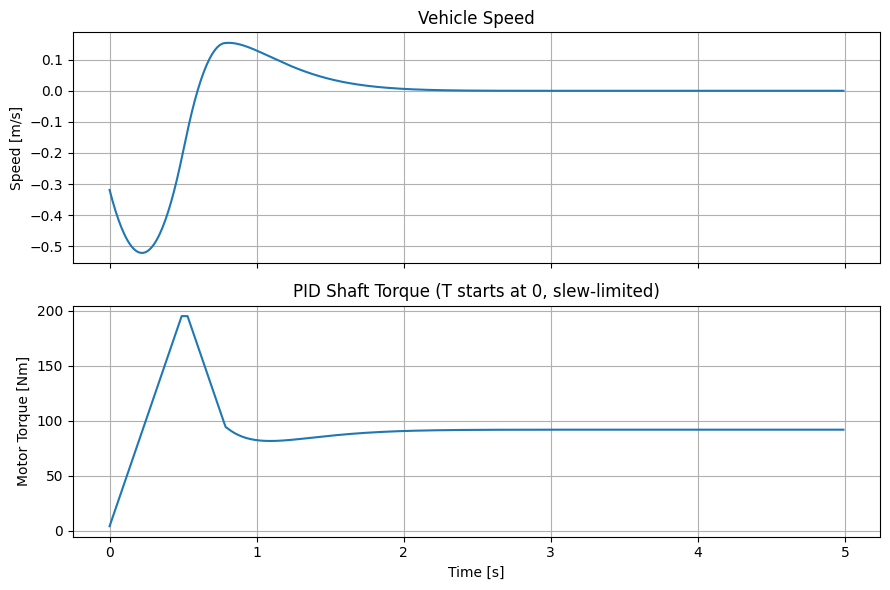

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# physical parameters ---------------------------------------------------
m, r_tire, g = 1500.0, 0.35, 9.81
theta = np.deg2rad(11.5)
F_dist = m * g * np.sin(theta) + 14.0
gear_ratio, eff = 12.5, 0.90
i_eff = gear_ratio * eff

# PID gains --------------------------------------------------------------
Kp, Ki, Kd = 4000.0, 8000.0, 80.0

# limits ----------------------------------------------------------------
T_MAX  = 150 * gear_ratio * eff * 1.30        # ≈ 2 194 Nm
T_SLEW = 2 * T_MAX                            # ≈ 4 388 Nm / s

# sim setup --------------------------------------------------------------
dt, t_end = 0.01, 5.0
N = int(t_end/dt)
time = np.arange(N)*dt

v       = -0.3        # initial speed   [m/s]
v_ref   = 0.0
int_e   = 0.0
prev_e  = 0.0
T_act   = 0.0         # ♦ uygulanacak tork 0’dan başlar

v_log   = np.zeros(N)
Tshaft  = np.zeros(N)

for k in range(N):
    e   = v_ref - v
    int_e += e*dt
    de  = (e - prev_e)/dt
    prev_e = e

    # ---------- PID çıkışı ----------
    T_cmd = Kp*e + Ki*int_e + Kd*de
    T_cmd = np.clip(T_cmd, -T_MAX, T_MAX)     # satürasyon

    # ---------- slew-rate filtresi ----------
    dT_allowed = T_SLEW * dt                  # adım başına izin verilen değişim
    T_act += np.clip(T_cmd - T_act, -dT_allowed, dT_allowed)

    # ---------- araç dinamiği ----------
    F_drive = T_act / r_tire
    a = (F_drive - F_dist) / m
    v += a*dt

    v_log[k]   = v
    Tshaft[k]  = T_act / i_eff

# plots ------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(9,6),sharex=True)

ax1.plot(time, v_log)
ax1.set_ylabel('Speed [m/s]')
ax1.set_title('Vehicle Speed')
ax1.grid(True)

ax2.plot(time, Tshaft)
ax2.set_ylabel('Motor Torque [Nm]')
ax2.set_xlabel('Time [s]')
ax2.set_title('PID Shaft Torque (T starts at 0, slew-limited)')
ax2.grid(True)

plt.tight_layout()
plt.show()
